In [84]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style = 'darkgrid',font_scale=1.5)

import warnings as ws
ws.filterwarnings('ignore')

In [85]:
# Displaying all the columns
pd.pandas.set_option('display.max_columns',None)

In [86]:
# Reading the file
df = pd.read_csv('mobiles1.csv')
df.head()

,battery,camera,display,memory,name,price,processor,rating,reviews,warranty
0,5000 mAh Battery,12MP + 2MP | 8MP Front Camera,15.8 cm (6.22 inch) HD+ Display,4 GB RAM | 64 GB ROM | Expandable Upto 512 GB,"Redmi 8 (Ruby Red, 64 GB)",9999,Qualcomm Snapdragon 439 Processor,4.4,"55,078 Reviews",Brand Warranty of 1 Year Available for Mobile ...
1,5000 mAh Battery,12MP + 8MP + 2MP + 2MP | 8MP Front Camera,16.56 cm (6.52 inch) HD+ Display,4 GB RAM | 64 GB ROM,"Realme 5i (Aqua Blue, 64 GB)",10999,Qualcomm Snapdragon 665 2 GHz Processor,4.5,"20,062 Reviews",Sunrise Design
2,5000 mAh Battery,12MP + 8MP + 2MP + 2MP | 8MP Front Camera,16.56 cm (6.52 inch) HD+ Display,4 GB RAM | 128 GB ROM,"Realme 5i (Aqua Blue, 128 GB)",11999,Qualcomm Snapdragon 665 (2 GHz) Processor,4.5,"20,062 Reviews",Sunrise Design
3,5000 mAh Battery,12MP + 8MP + 2MP + 2MP | 8MP Front Camera,16.56 cm (6.52 inch) HD+ Display,4 GB RAM | 128 GB ROM,"Realme 5i (Forest Green, 128 GB)",11999,Qualcomm Snapdragon 665 (2 GHz) Processor,4.5,"20,062 Reviews",Sunrise Design
4,4000 mAh Battery,13MP + 2MP | 5MP Front Camera,15.49 cm (6.1 inch) HD+ Display,3 GB RAM | 32 GB ROM | Expandable Upto 256 GB,"Realme C2 (Diamond Blue, 32 GB)",7499,MediaTek P22 Octa Core 2.0 GHz Processor,4.4,"10,091 Reviews",Dual Nano SIM slots and Memory Card Slot


In [87]:
df.shape

(984, 10)

In [88]:
df.describe()

,price,rating
count,984.000000,971.000000
mean,15429.848577,4.241195
std,12891.355967,0.300296
min,887.000000,2.700000
25%,7499.000000,4.100000
50%,11649.000000,4.300000
75%,17999.250000,4.400000
max,104999.000000,4.900000


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   battery    984 non-null    object 
 1   camera     984 non-null    object 
 2   display    984 non-null    object 
 3   memory     984 non-null    object 
 4   name       984 non-null    object 
 5   price      984 non-null    int64  
 6   processor  983 non-null    object 
 7   rating     971 non-null    float64
 8   reviews    971 non-null    object 
 9   warranty   836 non-null    object 
dtypes: float64(1), int64(1), object(8)
memory usage: 77.0+ KB


# Data Cleaning

### Some data from processor and warranty columns are interchanged 
### Using regex patterns here

### Step 1 : The data interchanged in these two columns (processor,warranty) are brought back to their original columns

In [90]:
df.isna().sum()

battery        0
camera         0
display        0
memory         0
name           0
price          0
processor      1
rating        13
reviews       13
warranty     148
dtype: int64

In [91]:
processor_pattern = r'(snapdragon|mediatek|qualcomm|mtk|helio|processor|samsung|exynos|kirin|unisoc|Hisilicon|spreadtrum)'
warranty_pattern = r'(warranty|year|years|ear|month|months|replacement|manufacturer|brand)'

### Step 2 : Move interchanged values 
### Warranty text wrongly placed inside processor

In [92]:
mask_proc_is_warranty = df['processor'].str.contains(warranty_pattern,case=False,na=False)

# Moving the invalid values from processor to warranty if warranty is missing
df.loc[mask_proc_is_warranty & df['warranty'].isna(),'warranty'] = df.loc[mask_proc_is_warranty & df['warranty'].isna(),'processor']

df.loc[mask_proc_is_warranty,'processor'] = np.nan

### Processor text wrongly placed inside warranty

In [93]:
mask_warr_is_processor = df['warranty'].str.contains(processor_pattern,case=False,na=False)

# Moving the invalid values from warranty to processor if processor is missing
df.loc[mask_warr_is_processor & df['processor'].isna(),'processor'] = df.loc[mask_warr_is_processor & df['processor'].isna(),'warranty']

df.loc[mask_warr_is_processor,'warranty'] = np.nan

In [94]:
df['processor']=df['processor'].where(df['processor'].str.contains(processor_pattern,case=False,na=False),np.nan)
df['warranty'] = df['warranty'].where(df['warranty'].str.contains(warranty_pattern,case=False,na=False),np.nan)

## Observation
### The dataset contained column interchange between processor and warranty fields due to scraping inconsistencies.
### semantically classified text using regex patterns and reassigning values to their appropriate columns before final validation.

In [95]:
df.isna().sum()

battery        0
camera         0
display        0
memory         0
name           0
price          0
processor    149
rating        13
reviews       13
warranty     208
dtype: int64

In [96]:
# Creating new columns with the segregated values
df['brand']=df['name'].str.split().str[0]
df['reviews'] = (df['reviews'].str.replace(',','',regex=True)
                 .str.extract(r'(\d+)',expand=False)
                 .astype(float))
df['ram_gb'] = df['memory'].str.split('|').str[0]
df['storage_gb'] = df['memory'].str.split('|').str[1]
df['expandable_storage'] = df['memory'].str.extract(r'(Expandable[^|]*)',expand=False)
rear_mp_list=df['camera'].str.split('|').str[0].str.findall(r'(\d+)\s*MP')
df['rear_camera_count'] = rear_mp_list.apply(len)
df['rear_camera_mp']=df['camera'].str.split('|').str[0]
df['front_camera_mp']=df['camera'].str.split('|').str[1]
df['battery_clean'] = df['battery'].str.replace('\n', ' ', regex=False).str.lower().str.strip()
df['battery_mah'] = df['battery_clean'].str.extract(r'(\d+\s*mah)', expand=False)
df['battery_type']=df['battery_clean'].str.extract(r'mah\s*(.*)',expand=False)

### Changing the order of columns

In [97]:
df = df[['brand','display','processor','ram_gb','storage_gb','expandable_storage','battery_type',
        'battery_mah','rear_camera_mp','front_camera_mp','rear_camera_count','rating','reviews','warranty','price']]

### Removing the extra spaces

In [98]:
def clean_text(col):
    return (
        col.astype(str)
        .str.strip()
        .str.replace(r'\s+',' ',regex=True)
    )

In [99]:
df['ram_gb'] = clean_text(df['ram_gb'])
df['storage_gb'] = clean_text(df['storage_gb'])
df['rear_camera_mp'] = clean_text(df['rear_camera_mp'])

In [100]:
for feature in df.columns:
    print(feature)
    print(df[feature].unique())
    print('-----------------------')

brand
['Redmi' 'Realme' 'Tecno' 'POCO' 'Infinix' 'OPPO' 'Motorola' 'Vivo'
 'Samsung' 'iQOO' 'Nokia' 'Honor' 'Lava' 'Asus' 'OnePlus' 'Panasonic' 'Mi'
 'Huawei' 'Coolpad' 'Micromax' 'LG' 'Itel' 'Gionee' 'XOLO' 'Alcatel'
 'Moto' 'YUHO' 'Lenovo' 'Karbonn' 'ITEL' 'Kenxinda' 'Google' 'Celkon'
 'VOTO' 'Mobiistar' 'Meizu' 'Intex' 'Forme' 'Blackbear' 'Yu' 'Comio'
 'ZOPO' 'Black' 'Homtom' 'InFocus' 'MI3' 'Zen' 'Ringme' 'Gome' 'Voto'
 'vivo' 'LYF' 'Ziox' 'Nextbit']
-----------------------
display
['15.8 cm (6.22 inch) HD+ Display' '16.56 cm (6.52 inch) HD+ Display'
 '15.49 cm (6.1 inch) HD+ Display' '17.78 cm (7 inch) HD+ Display'
 '16.51 cm (6.5 inch) Full HD+ Display'
 '16.94 cm (6.67 inch) Full HD+ Display' '16.76 cm (6.6 inch) HD+ Display'
 '16.51 cm (6.5 inch) Display' '17.32 cm (6.82 inch) HD+ Display'
 '15.75 cm (6.2 inch) HD+ Display' '16.13 cm (6.35 inch) HD+ Display'
 '16.0 cm (6.3 inch) Full HD+ Display'
 '16.59 cm (6.53 inch) Full HD+ Display'
 '16.21 cm (6.38 inch) Full HD+ Display'


In [101]:
import re
df['display_inch'] =(df['display']
                    .str.extract(r'\((\d+\.?\d*)\s*(?:inch|inches|"|in)',flags = re.IGNORECASE)
                    .astype(float))

In [102]:
df['battery_mah'] = (df['battery_mah']
                    .str.extract(r'(\d+)')
                    .astype(float))

In [103]:
df['rear_camera_mp'] = (df['rear_camera_mp']
                        .str.findall(r'(\d+)')
                        .apply(lambda x: sum(map(int,x)) if len(x) > 0 else None))

In [104]:
df['front_camera_mp'] = (df['front_camera_mp']
                        .str.extract(r'(\d+)')
                        .astype(float))

In [105]:
df.drop(columns='display',inplace=True)

In [106]:
df['battery_type']=df['battery_type'].replace({'battery':'standard battery'})

### Grouping all the same familyprocessor 

In [107]:
def extract_processor(text):
    if pd.isna(text):
        return np.nan

    text = text.lower()

    if re.search(r'snapdragon',text):
        return 'Snapdragon'
    elif re.search(r'mediatek|mtk|helio',text):
        return 'Mediatek'
    elif re.search(r'exynos',text):
        return 'Exynos'
    elif re.search(r'kirin|hisilicon',text):
        return 'Kirin'
    elif re.search(r'unisoc',text):
        return 'Unisoc'
    elif re.search(r'spreadtrum',text):
        return 'Spreadtrum'
    elif re.search(r'cortex|arm',text):
        return 'ARM'
    else:
        return 'Other'

In [108]:
df['processor_family'] = df['processor'].apply(extract_processor)

In [109]:
def extract_warranty(text):
    if pd.isna(text):
        return np.nan

    text = text.lower()

    year_match = re.search(r'(\d+)\s*(years|year|yr|ear)',text)
    if year_match:
        return int(year_match.group(1)) * 12
    month_match = re.search(r'(\d+)\s*(month|months)',text)
    if month_match:
        return int(month_match.group(1))
    else:
        return np.nan

In [110]:
df['warranty_months'] = df['warranty'].apply(extract_warranty)

In [111]:
df.drop(columns=['processor','warranty'],inplace=True)

In [112]:
#Finding the missing values
features_with_nan = [feature for feature in df.columns if df[feature].isna().sum() > 0]
for feature in features_with_nan:
    print(f'{feature} : {df[feature].isna().sum()}')

expandable_storage : 249
front_camera_mp : 92
rating : 13
reviews : 13
processor_family : 149
warranty_months : 209


In [113]:
# Finding the percentage of missing values
for feature in features_with_nan:
    print(f'{feature} : {round(df[feature].isna().mean(),4)}% missing values')

expandable_storage : 0.253% missing values
front_camera_mp : 0.0935% missing values
rating : 0.0132% missing values
reviews : 0.0132% missing values
processor_family : 0.1514% missing values
warranty_months : 0.2124% missing values


<Axes: >

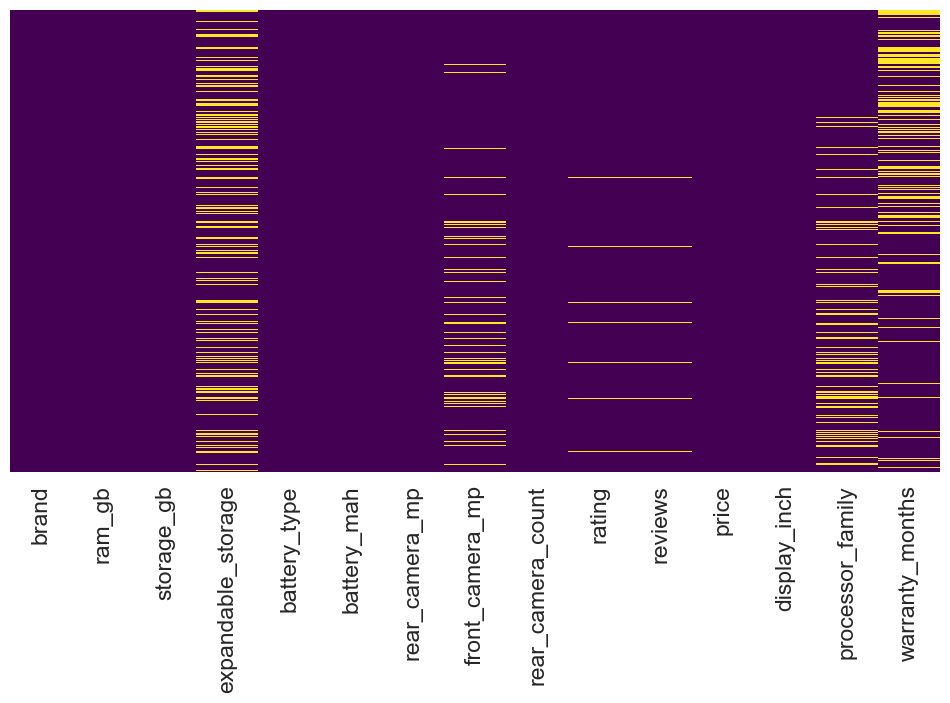

In [114]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12,6)
sns.heatmap(df.isna(),yticklabels=False,cbar=False,cmap='viridis')

In [115]:
cat_var = [feature for feature in df.columns if df[feature].dtypes == 'O']
for feature in cat_var:
    print(f'The feature is {feature} and no of categories are {len(df[feature].unique())}')

The feature is brand and no of categories are 54
The feature is ram_gb and no of categories are 12
The feature is storage_gb and no of categories are 10
The feature is expandable_storage and no of categories are 12
The feature is battery_type and no of categories are 15
The feature is processor_family and no of categories are 9


In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   brand               984 non-null    object 
 1   ram_gb              984 non-null    object 
 2   storage_gb          984 non-null    object 
 3   expandable_storage  735 non-null    object 
 4   battery_type        984 non-null    object 
 5   battery_mah         984 non-null    float64
 6   rear_camera_mp      984 non-null    int64  
 7   front_camera_mp     892 non-null    float64
 8   rear_camera_count   984 non-null    int64  
 9   rating              971 non-null    float64
 10  reviews             971 non-null    float64
 11  price               984 non-null    int64  
 12  display_inch        984 non-null    float64
 13  processor_family    835 non-null    object 
 14  warranty_months     775 non-null    float64
dtypes: float64(6), int64(3), object(6)
memory usage: 115.4+ K

In [117]:
# Exporting the file
df.to_csv('mobiles_for_eda.csv')